## Генерация изображений котов (64x64) при помощи GAN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization, Reshape, Flatten, Conv2DTranspose, Conv2D, LeakyReLU, UpSampling2D, MaxPool2D
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, Adagrad, SGD
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import initializers
from PIL import Image
import pickle

Обучающая выборка - набор 30000 изображений

In [2]:
# im_list_train=[]
# for pic in os.listdir('./dataset'):
#     img = Image.open("./dataset/" + pic).convert("RGB")
#     img = np.array(img).reshape((64, 64, 3))
#     im_list_train.append(img)
       
# x_train = (np.array(im_list_train).astype(np.float32) - 127.5)/127.5

In [3]:
# with open('x_train_large.pkl', 'wb') as f:
#     pickle.dump(x_train, f)

In [4]:
with open("x_train_large.pkl", "rb") as file_to_read:
    x_train = pickle.load(file_to_read)

In [5]:
random_dim = 60

In [6]:
x_train.shape

(29843, 64, 64, 3)

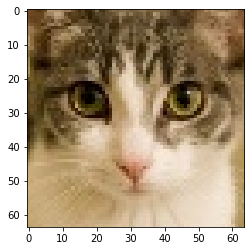

In [7]:
plt.imshow(x_train[19]/2+.5);

In [8]:
def get_optimizer_discriminator():
    return Adam(learning_rate=0.00015, beta_1=0.4)
def get_optimizer_gan():
    return Adam(learning_rate=0.00015, beta_1=0.5)

In [9]:
gen_l1 = 0.00001
gen_l2 = 0.000006
dis_l1 = 0.000008
dis_l2 = 0.000004

In [10]:
def get_generator():
    model = Sequential()
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=random_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
#     model.add(Dropout(0.1))
    
    model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.1))
    
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.2))
    
    model.add(Conv2D(128, (1,1), strides=(1,1), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.2))

    
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.2))

    
    model.add(Conv2DTranspose(64, (4,4), strides=(2,2), padding='same', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
#     model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
#     model.add(Dropout(0.2))

    
    model.add(Conv2D(3, (1,1), activation='tanh', padding='valid', kernel_regularizer=l1_l2(gen_l1, gen_l2)))
    return model


def get_discriminator(optimizer):
    model = Sequential()
    
    model.add(Conv2D(64, (3,3), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2), input_shape=[64, 64, 3]))
    model.add(LeakyReLU(alpha=0.25))
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    model.add(MaxPool2D())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(256, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    model.add(MaxPool2D())
    model.add(Dropout(0.5))

    model.add(Conv2D(512, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
#     model.add(MaxPool2D())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(800, (3,3), strides=(1,1), padding='valid', kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    model.add(Dropout(0.5))
#     model.add(MaxPool2D())

    model.add(Flatten())
    
    model.add(Dense(512, kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    
    model.add(Dense(128, kernel_regularizer=l1_l2(dis_l1, dis_l2)))
    model.add(LeakyReLU(alpha=0.25))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model



In [11]:
# get_generator().summary()

In [12]:
get_discriminator(Adam()).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 29, 29, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 29, 29, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 128)       0

In [13]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    discriminator.trainable = False
    # Вход модели - многомерный гауссовский шум
    gan_input = Input(shape=(random_dim,))
    x = generator(gan_input)
    # Выход модели - выход дискриминатора
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [14]:
# Визуализация и сохранение в файл
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10), figsize=(16, 16)):
    noise = np.random.normal(0, 1, size=[examples, random_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images / 2 + 0.5

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.axis('off')
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
    filename = 'image_%03d.png' % epoch
    plt.savefig(filename)
    plt.close()


In [15]:
def train(epochs=1, batch_size=128):
    batch_count = int(x_train.shape[0] / batch_size)

    # Построение модели GAN
    generator = get_generator()
    optimizer_discriminator = get_optimizer_discriminator()
    discriminator = get_discriminator(optimizer_discriminator)
    optimizer_gan = get_optimizer_gan()
    gan = get_gan_network(discriminator, random_dim, generator, optimizer_gan)
    history_gen = []
    history_dis = []
    pbar = tqdm()
    
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        
        for j in range(batch_count):
            # Генерируем случайный набор входного шума и изображений 
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Генерируем фейковые изображения
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Метки для настоящих изображений (0.95) и фейковых (.05) + шум
            y_dis = np.zeros(2 * batch_size) + .1
            # Label smoothing
            y_dis[:batch_size] = .9
            # Добавление небольшого шума в метки
            y_dis += 0.05 * np.random.random(y_dis.shape)

            # Шаг обучения дискриминатора
            discriminator.trainable = True
            history_dis += [discriminator.train_on_batch(X, y_dis)[0]]

            # Шаг обучения генератора
            discriminator.trainable = False
            noise = np.random.normal(0, 1, size=[batch_size, random_dim])
            y_gen = np.ones(batch_size)
            gen_loss = gan.train_on_batch(noise, y_gen)
            history_gen += [gen_loss]

            pbar.set_description(f'Generator loss: {round(gen_loss, 3)}.  Discriminator loss: {round(history_dis[-1], 3)}')
            pbar.update(j / batch_count)

        if e % 5 == 0:
            plot_generated_images(e, generator)
    return generator, history_gen, history_dis

train_results = train(800, 64)

0it [00:00, ?it/s]

--------------- Epoch 1 ---------------


Generator loss: 2.074.  Discriminator loss: 1.223: : 232.49999999999994it [01:02,  8.22it/s]  

--------------- Epoch 2 ---------------


Generator loss: 2.015.  Discriminator loss: 1.044: : 464.99999999999994it [02:01,  8.21it/s]

--------------- Epoch 3 ---------------


Generator loss: 1.939.  Discriminator loss: 0.994: : 697.5it [03:00,  7.62it/s]             

--------------- Epoch 4 ---------------


Generator loss: 1.798.  Discriminator loss: 0.897: : 930.0it [03:59,  7.70it/s]            

--------------- Epoch 5 ---------------


Generator loss: 2.106.  Discriminator loss: 0.875: : 1162.5it [04:59,  7.76it/s]            

--------------- Epoch 6 ---------------


Generator loss: 2.085.  Discriminator loss: 0.853: : 1395.0it [05:57,  8.06it/s]            

--------------- Epoch 7 ---------------


Generator loss: 2.332.  Discriminator loss: 0.841: : 1627.5it [06:56,  7.95it/s]            

--------------- Epoch 8 ---------------


Generator loss: 1.744.  Discriminator loss: 0.877: : 1860.0it [07:54,  7.90it/s]            

--------------- Epoch 9 ---------------


Generator loss: 2.141.  Discriminator loss: 0.843: : 2092.4999999999995it [08:53,  7.51it/s]

--------------- Epoch 10 ---------------


Generator loss: 1.855.  Discriminator loss: 0.84: : 2324.9999999999995it [09:53,  8.09it/s] 

--------------- Epoch 11 ---------------


Generator loss: 1.704.  Discriminator loss: 0.788: : 2557.4999999999995it [10:52,  8.27it/s]

--------------- Epoch 12 ---------------


Generator loss: 2.039.  Discriminator loss: 0.816: : 2789.9999999999995it [11:51,  8.06it/s]

--------------- Epoch 13 ---------------


Generator loss: 1.682.  Discriminator loss: 0.834: : 3022.4999999999995it [12:49,  8.01it/s]

--------------- Epoch 14 ---------------


Generator loss: 1.701.  Discriminator loss: 0.812: : 3254.9999999999995it [13:48,  7.93it/s]

--------------- Epoch 15 ---------------


Generator loss: 1.74.  Discriminator loss: 0.775: : 3487.4999999999995it [14:48,  7.70it/s] 

--------------- Epoch 16 ---------------


Generator loss: 1.658.  Discriminator loss: 0.794: : 3719.9999999999995it [15:47,  8.05it/s]

--------------- Epoch 17 ---------------


Generator loss: 1.582.  Discriminator loss: 0.83: : 3952.4999999999995it [16:45,  7.74it/s] 

--------------- Epoch 18 ---------------


Generator loss: 1.603.  Discriminator loss: 0.77: : 4184.999999999998it [17:45,  7.80it/s]  

--------------- Epoch 19 ---------------


Generator loss: 1.596.  Discriminator loss: 0.843: : 4417.499999999998it [18:44,  7.75it/s] 

--------------- Epoch 20 ---------------


Generator loss: 1.688.  Discriminator loss: 0.852: : 4649.999999999998it [19:44,  8.59it/s] 

--------------- Epoch 21 ---------------


Generator loss: 1.51.  Discriminator loss: 0.85: : 4882.499999999998it [20:42,  8.24it/s]   

--------------- Epoch 22 ---------------


Generator loss: 1.728.  Discriminator loss: 0.776: : 5114.999999999998it [21:41,  7.89it/s] 

--------------- Epoch 23 ---------------


Generator loss: 1.763.  Discriminator loss: 0.831: : 5347.499999999998it [22:40,  7.85it/s] 

--------------- Epoch 24 ---------------


Generator loss: 1.528.  Discriminator loss: 0.836: : 5579.999999999998it [23:39,  8.15it/s] 

--------------- Epoch 25 ---------------


Generator loss: 1.662.  Discriminator loss: 0.825: : 5812.499999999998it [24:39,  8.61it/s] 

--------------- Epoch 26 ---------------


Generator loss: 1.58.  Discriminator loss: 0.837: : 6044.999999999998it [25:38,  7.85it/s]  

--------------- Epoch 27 ---------------


Generator loss: 1.675.  Discriminator loss: 0.767: : 6277.499999999998it [26:36,  8.01it/s] 

--------------- Epoch 28 ---------------


Generator loss: 1.506.  Discriminator loss: 0.815: : 6509.999999999998it [27:35,  7.98it/s] 

--------------- Epoch 29 ---------------


Generator loss: 1.488.  Discriminator loss: 0.79: : 6742.499999999998it [28:33,  7.71it/s]  

--------------- Epoch 30 ---------------


Generator loss: 1.534.  Discriminator loss: 0.801: : 6974.999999999998it [29:34,  8.05it/s] 

--------------- Epoch 31 ---------------


Generator loss: 1.676.  Discriminator loss: 0.782: : 7207.499999999998it [30:33,  7.63it/s] 

--------------- Epoch 32 ---------------


Generator loss: 1.507.  Discriminator loss: 0.792: : 7439.999999999998it [31:32,  7.56it/s] 

--------------- Epoch 33 ---------------


Generator loss: 1.505.  Discriminator loss: 0.841: : 7672.499999999998it [32:30,  7.93it/s] 

--------------- Epoch 34 ---------------


Generator loss: 1.592.  Discriminator loss: 0.822: : 7904.999999999998it [33:28,  7.86it/s] 

--------------- Epoch 35 ---------------


Generator loss: 1.722.  Discriminator loss: 0.813: : 8137.499999999998it [34:29,  8.18it/s] 

--------------- Epoch 36 ---------------


Generator loss: 1.606.  Discriminator loss: 0.798: : 8369.999999999998it [35:28,  8.01it/s] 

--------------- Epoch 37 ---------------


Generator loss: 1.513.  Discriminator loss: 0.819: : 8602.499999999998it [36:26,  8.39it/s]

--------------- Epoch 38 ---------------


Generator loss: 1.581.  Discriminator loss: 0.835: : 8834.999999999998it [37:25,  8.07it/s]

--------------- Epoch 39 ---------------


Generator loss: 1.582.  Discriminator loss: 0.839: : 9067.499999999998it [38:24,  8.18it/s]

--------------- Epoch 40 ---------------


Generator loss: 1.611.  Discriminator loss: 0.803: : 9299.999999999998it [39:24,  7.81it/s]

--------------- Epoch 41 ---------------


Generator loss: 1.568.  Discriminator loss: 0.795: : 9532.499999999998it [40:24,  7.84it/s]

--------------- Epoch 42 ---------------


Generator loss: 1.579.  Discriminator loss: 0.804: : 9764.999999999998it [41:22,  7.81it/s]

--------------- Epoch 43 ---------------


Generator loss: 1.554.  Discriminator loss: 0.839: : 9997.499999999998it [42:21,  8.06it/s]

--------------- Epoch 44 ---------------


Generator loss: 1.532.  Discriminator loss: 0.872: : 10229.999999999998it [43:20,  8.26it/s]

--------------- Epoch 45 ---------------


Generator loss: 1.638.  Discriminator loss: 0.808: : 10462.499999999998it [44:21,  7.80it/s]

--------------- Epoch 46 ---------------


Generator loss: 1.516.  Discriminator loss: 0.801: : 10694.999999999998it [45:19,  8.13it/s]

--------------- Epoch 47 ---------------


Generator loss: 1.438.  Discriminator loss: 0.804: : 10927.499999999998it [46:18,  7.92it/s]

--------------- Epoch 48 ---------------


Generator loss: 1.636.  Discriminator loss: 0.821: : 11159.999999999998it [47:16,  8.45it/s]

--------------- Epoch 49 ---------------


Generator loss: 1.47.  Discriminator loss: 0.782: : 11392.499999999998it [48:15,  7.89it/s] 

--------------- Epoch 50 ---------------


Generator loss: 1.738.  Discriminator loss: 0.851: : 11624.999999999998it [49:16,  8.52it/s]

--------------- Epoch 51 ---------------


Generator loss: 1.509.  Discriminator loss: 0.824: : 11857.499999999998it [50:14,  7.77it/s]

--------------- Epoch 52 ---------------


Generator loss: 1.68.  Discriminator loss: 0.826: : 12089.999999999998it [51:13,  7.78it/s] 

--------------- Epoch 53 ---------------


Generator loss: 1.527.  Discriminator loss: 0.782: : 12322.499999999998it [52:12,  7.83it/s]

--------------- Epoch 54 ---------------


Generator loss: 1.628.  Discriminator loss: 0.85: : 12554.999999999998it [53:10,  7.70it/s] 

--------------- Epoch 55 ---------------


Generator loss: 1.577.  Discriminator loss: 0.837: : 12787.499999999998it [54:10,  7.44it/s]

--------------- Epoch 56 ---------------


Generator loss: 1.547.  Discriminator loss: 0.836: : 13019.999999999998it [55:08,  8.50it/s]

--------------- Epoch 57 ---------------


Generator loss: 1.477.  Discriminator loss: 0.805: : 13252.499999999998it [56:07,  8.08it/s]

--------------- Epoch 58 ---------------


Generator loss: 1.585.  Discriminator loss: 0.865: : 13484.999999999998it [57:05,  7.61it/s]

--------------- Epoch 59 ---------------


Generator loss: 1.563.  Discriminator loss: 0.829: : 13717.499999999998it [58:05,  7.52it/s]

--------------- Epoch 60 ---------------


Generator loss: 1.647.  Discriminator loss: 0.8: : 13949.999999999998it [59:05,  7.96it/s]  

--------------- Epoch 61 ---------------


Generator loss: 1.51.  Discriminator loss: 0.828: : 14182.499999999998it [1:00:03,  8.03it/s] 

--------------- Epoch 62 ---------------


Generator loss: 1.698.  Discriminator loss: 0.825: : 14414.999999999998it [1:01:01,  7.90it/s]

--------------- Epoch 63 ---------------


Generator loss: 1.776.  Discriminator loss: 0.816: : 14647.499999999998it [1:02:00,  8.27it/s]

--------------- Epoch 64 ---------------


Generator loss: 1.472.  Discriminator loss: 0.8: : 14879.999999999998it [1:02:59,  7.63it/s]  

--------------- Epoch 65 ---------------


Generator loss: 1.593.  Discriminator loss: 0.835: : 15112.499999999998it [1:03:59,  8.28it/s]

--------------- Epoch 66 ---------------


Generator loss: 1.595.  Discriminator loss: 0.787: : 15344.999999999998it [1:04:58,  8.14it/s]

--------------- Epoch 67 ---------------


Generator loss: 1.582.  Discriminator loss: 0.846: : 15577.499999999998it [1:05:56,  8.13it/s]

--------------- Epoch 68 ---------------


Generator loss: 1.495.  Discriminator loss: 0.825: : 15809.999999999998it [1:06:55,  7.87it/s]

--------------- Epoch 69 ---------------


Generator loss: 1.518.  Discriminator loss: 0.792: : 16042.499999999998it [1:07:54,  8.31it/s]

--------------- Epoch 70 ---------------


Generator loss: 1.534.  Discriminator loss: 0.84: : 16274.999999999998it [1:08:55,  7.42it/s] 

--------------- Epoch 71 ---------------


Generator loss: 1.812.  Discriminator loss: 0.827: : 16507.500000000004it [1:09:53,  7.81it/s]

--------------- Epoch 72 ---------------


Generator loss: 1.626.  Discriminator loss: 0.843: : 16740.000000000004it [1:10:52,  8.34it/s]

--------------- Epoch 73 ---------------


Generator loss: 1.57.  Discriminator loss: 0.83: : 16972.500000000004it [1:11:50,  7.94it/s]  

--------------- Epoch 74 ---------------


Generator loss: 1.518.  Discriminator loss: 0.78: : 17205.000000000004it [1:12:49,  7.48it/s] 

--------------- Epoch 75 ---------------


Generator loss: 1.499.  Discriminator loss: 0.857: : 17437.500000000004it [1:13:50,  7.68it/s]

--------------- Epoch 76 ---------------


Generator loss: 1.604.  Discriminator loss: 0.795: : 17670.000000000004it [1:14:48,  8.04it/s]

--------------- Epoch 77 ---------------


Generator loss: 1.613.  Discriminator loss: 0.834: : 17902.500000000004it [1:15:47,  7.77it/s]

--------------- Epoch 78 ---------------


Generator loss: 1.556.  Discriminator loss: 0.796: : 18135.000000000004it [1:16:45,  7.79it/s]

--------------- Epoch 79 ---------------


Generator loss: 1.726.  Discriminator loss: 0.835: : 18367.500000000004it [1:17:44,  7.96it/s]

--------------- Epoch 80 ---------------


Generator loss: 1.406.  Discriminator loss: 0.82: : 18600.000000000004it [1:18:44,  7.66it/s] 

--------------- Epoch 81 ---------------


Generator loss: 1.434.  Discriminator loss: 0.872: : 18832.500000000004it [1:19:43,  7.70it/s]

--------------- Epoch 82 ---------------


Generator loss: 1.576.  Discriminator loss: 0.813: : 19065.000000000004it [1:20:42,  7.48it/s]

--------------- Epoch 83 ---------------


Generator loss: 1.396.  Discriminator loss: 0.819: : 19297.500000000004it [1:21:41,  7.81it/s]

--------------- Epoch 84 ---------------


Generator loss: 1.418.  Discriminator loss: 0.832: : 19530.000000000004it [1:22:40,  8.31it/s]

--------------- Epoch 85 ---------------


Generator loss: 1.56.  Discriminator loss: 0.775: : 19762.500000000004it [1:23:39,  7.85it/s] 

--------------- Epoch 86 ---------------


Generator loss: 1.725.  Discriminator loss: 0.821: : 19995.000000000004it [1:24:38,  7.66it/s]

--------------- Epoch 87 ---------------


Generator loss: 1.581.  Discriminator loss: 0.878: : 20227.500000000004it [1:25:36,  7.95it/s]

--------------- Epoch 88 ---------------


Generator loss: 1.525.  Discriminator loss: 0.813: : 20460.000000000004it [1:26:35,  7.87it/s]

--------------- Epoch 89 ---------------


Generator loss: 1.475.  Discriminator loss: 0.827: : 20692.500000000004it [1:27:34,  7.85it/s]

--------------- Epoch 90 ---------------


Generator loss: 1.557.  Discriminator loss: 0.804: : 20925.000000000004it [1:28:34,  8.10it/s]

--------------- Epoch 91 ---------------


Generator loss: 1.548.  Discriminator loss: 0.848: : 21157.500000000004it [1:29:33,  7.76it/s]

--------------- Epoch 92 ---------------


Generator loss: 1.672.  Discriminator loss: 0.825: : 21390.000000000004it [1:30:32,  7.92it/s]

--------------- Epoch 93 ---------------


Generator loss: 1.585.  Discriminator loss: 0.874: : 21622.500000000004it [1:31:31,  7.70it/s]

--------------- Epoch 94 ---------------


Generator loss: 1.664.  Discriminator loss: 0.799: : 21855.000000000004it [1:32:29,  7.69it/s]

--------------- Epoch 95 ---------------


Generator loss: 1.524.  Discriminator loss: 0.811: : 22087.500000000004it [1:33:30,  8.43it/s]

--------------- Epoch 96 ---------------


Generator loss: 1.56.  Discriminator loss: 0.848: : 22320.000000000004it [1:34:28,  8.22it/s] 

--------------- Epoch 97 ---------------


Generator loss: 1.663.  Discriminator loss: 0.837: : 22370.29184549356it [1:34:55,  3.63it/s] 

KeyboardInterrupt: 

In [ ]:
def show_generated_image(epoch_number):
    plt.figure(figsize=(22, 22))
    plt.axis('off')
    plt.imshow(Image.open(f'generated_large_e{epoch_number}.png').crop((150, 130, 850, 830)), aspect=.75);

In [ ]:
show_generated_image('010')